## Modelling

**Summary**
- The results of these models is affected by data leakage, it was caused during the pre-processing notebook when I performed the scaling
- Overall, the best model has been Random Forest, I will continue with this algorithm for the final results, tunning and running it again without data leakage
- The best iteration of the Random Forest had an accuracy of 96, recall of 97 and precision of 98. Summarized in a ROC AUC of 98 and F1 of 97
    - Parameters: Standard Scaler, no PCA and max depth = 100, cross - validation = 3

**Algorithms**

- In the evaluation for the final model, careful consideration was given to weighting precision, recall, overfitting, the number of parameters, and runtime, leading to the decision to continue with the random forest algorithm.


KNN

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      | different number of neighbors       |0.81        |underperform vs baseline, and used the maximum number of neighbors       |
| 2   | Increased neighbors to a range 200        |0.84        |Accuracy increased, but continued to underperform. Also used the maximum number of neighbors        |
| 3   | Increased the number of neighbors to a 1000 range        |0.84        |The number of neighbors stayed on the lower bound. Optimum number ≈ 200       |
| 4   | Weight by distance        |0.91        |Significant improvement. Accuracy surpasses the baseline        |

- The KNN algorithm proved ineffective in finding meaningful patterns and exhibited slow fitting times due to the large number of features. However, a significant increase in accuracy was observed upon switching to the 'distance' metric, which assigns weights to points based on the inverse of their distance.
- The presence of irrelevant features in the dataset, coupled with the default weight that treats all features equally, introduces unnecessary noise into the calculations.
- Considering the number of features and datapoints, it is evident that this model is not efficient for predicting churn.


----------------------------------------------------------------------

Random Forest

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      |Max depth 10       |0.9 / 0.9 |No normalize and Standard Scaler, CV = 3. It used the upper bound of neighbors|
| 2   | Max depth increased range 10 - 20        |0.96 / 0.94 |The model used the upper bound|
| 3   | Max depth increased range 20 - 100        |0.96 / 0.95|The model used the upper bound|
| 4   | Max depth increased range 100 - 500        |0.97 / 0.96|100 maximum depth. The optimum parameter is ≈ 100|

- All iterations exceeded the baseline performance, and the models demonstrated significantly reduced processing time compared to KNN.
- The optimized maximum depth is approximately 100 levels; however, beyond 20 levels, diminishing marginal returns become evident.

----------------------------------------------------------------------

XGBoost

| Iteration      | Actions | Recall / Accuracy| Additional notes|
| ----------- | ----------- |----------- |----------- |
| 1      | Random Search 1: 20 iterations, cv 3       |accuracy 0.80       |scale pos weight 1, reg lambda 0.5, 100 estimators, max depth 3 (upper bound), learning rate 0.1, gamma 0.0001, cols sample by tree 0.8|
| 2   | Random search 2: 50 iterations, cv 3        |accuracy 0.81        |n components 0.9, scale pos weight 1, reg lambda 5, 100 estimators, max depth 1, learning rate 0.1, gamma 1, cols sample by tree 0.5|
| 3   | GridSearch 1        |Accuracy 0.84        |col sample by tree 0.8, gamma 0.0001, learning rate 0.01, max depth 4 (upper bound), n estimators 200, reg alpha 1, scale pos weight 1, no n components       |
| 4   | GridSearch 2 Range depth 4 - 15       |0.95 / 0.94        |15 max depth (upper bound), all the other parameters stayed the same   |
| 5   | GridSearch 3   Range depth 15 - 100     |0.95 / 0.94        |15 max depth (lower bound), all the other parameters stayed the same        |

- Given the extensive parameter set requiring optimization, I initiated the process with Random Search iterations to narrow down the parameter ranges.
- The optimized models outperformed the baseline accuracy.
- A random sample of 0.8 was utilized to introduce greater diversity in the trees, complemented by a small learning rate as the number of iterations was not a limiting factor. A low gamma value was chosen to account for the depth of the trees. Additionally, the scale positive weight was set to 1 due to the implementation of the SMOTE transformation.


In [2]:

#Imports:
#General imports
import numpy as np
import pandas as pd



# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


In [3]:
#Imports:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#Other models
from xgboost import XGBClassifier


#Sklearn metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [5]:
def get_estimators(estimator_name):
    if estimator_name == 'knn':
        estimators = [
            ('normalise', MinMaxScaler()),
            ('feature_selection', SelectKBest()), 
            ('model', KNeighborsClassifier())
        ]
    elif estimator_name == 'logreg':
        estimators = [
            ('normalise', StandardScaler()),
            ('model', LogisticRegression())
        ]
    elif estimator_name == 'svm':
        estimators = [
            ('normalise', StandardScaler()),
            ('model', SVC())
        ]
    elif estimator_name=='random_forest':
        estimators = [
            ('normalise', StandardScaler()),
            ('model', RandomForestClassifier())
        ]
    else:
        raise ValueError(f"Invalid estimator name: {estimator_name}")
    
    return estimators

In [6]:
def nan_vis(df):
    """
    Visualizes missing values in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - str: A message indicating if there are any missing values or not.
    - If there are missing values, returns a bar graph with the missing values.
    """

    # Visualize missing values
    if df.isna().sum().sum() == 0:
        return "There are no missing values"
    else:
        plt.figure(figsize=(10, 6))
        plt.title("Missing Values")
        ax = sns.barplot(x=df.columns, y=df.isna().sum())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.xlabel("Columns")
        plt.ylabel("Missing Values Count")
        plt.show()

In [7]:
#Uploading the files
def initial_sets():
    X_train_sm_ss = pd.read_csv('../Data/elenas-it1-x_train_sm_ss.csv', index_col=0)
    X_test_ss_sm = pd.read_csv('../Data/elenas-it1-x_test_sm_ss.csv', index_col=0)
    y_train_sm = pd.read_csv('../Data/elenas-it1-y_train_sm2.csv', index_col=0)
    y_test = pd.read_csv('../Data/elenas-it1-y_test.csv', index_col=0)
    #y_test = y_test["order_last_month"]
    #y_train_sm = y_train_sm["order_last_month"]
    return X_train_sm_ss, X_test_ss_sm, y_train_sm, y_test

In [8]:
#Defining the variables
X_train, X_test, y_train, y_test = initial_sets()

In [12]:
print(f"""
     X_train_sm_ss: {X_train.shape}
     X_test_ss_sm: {X_test.shape}
     y_train_sm: {y_train.shape}
     y_test: {y_test.shape}
      """)



     X_train_sm_ss: (377132, 28)
     X_test_ss_sm: (52623, 28)
     y_train_sm: (377132, 1)
     y_test: (52623, 1)
      


## KNN:

- The KNN algorithm proved ineffective in finding meaningful patterns and exhibited slow fitting times due to the large number of features. However, a significant increase in accuracy was observed upon switching to the 'distance' metric, which assigns weights to points based on the inverse of their distance.
- The presence of irrelevant features in the dataset, coupled with the default weight that treats all features equally, introduces unnecessary noise into the calculations.
- Considering the number of features and datapoints, it is evident that this model is not efficient for predicting churn.

Parameters:
- It 1:{'model': KNeighborsClassifier(n_neighbors=200), 'model__n_neighbors': 200, 'normalise': None, 'select': None}
- Best iteration with normal weight: {'model': KNeighborsClassifier(n_neighbors=200), 'model__n_neighbors': 200, 'normalise': None, 'select': None}
- Distance weight: 

-> first run: 


{'model': KNeighborsClassifier(n_neighbors=200), 'model__n_neighbors': 200, 'normalise': None, 'select': None}

Curse of dimensionality: kNN can struggle with high-dimensional data. When the number of features is large, the distance metric used by kNN may become less meaningful, and the algorithm might struggle to find meaningful patterns. Random Forest models, on the other hand, can handle high-dimensional data better by selecting subsets of features at each split.
Uninformative features: If the dataset contains irrelevant or noisy features, kNN might be more affected than the baseline or Random Forest models. kNN considers all features equally, and uninformative features can introduce unnecessary noise into the distance calculations. Random Forest models can automatically identify and ignore irrelevant features, whereas a baseline model might have pre-selected relevant features.

Iteration for KNN -> ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.




In [35]:
#KNN gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", KNeighborsClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [KNeighborsClassifier()],
        'normalise': [None],
        'model__n_neighbors': [200, 500, 1000],
        'select':  [None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
knn_fitted_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179:

In [36]:
print(knn_fitted_grid.best_params_)

{'model': KNeighborsClassifier(n_neighbors=200), 'model__n_neighbors': 200, 'normalise': None, 'select': None}


In [37]:
best_knn_accuracy = knn_fitted_grid.score(X_test, y_test)


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [38]:
print(best_knn_accuracy)

0.8406590274214697


In [113]:
#KNN gridsearch:
X_train, X_test, y_train, y_test = initial_sets()
knn_y_pred_prob = knn_fitted_grid.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, knn_y_pred_prob))

0.9354482574244878


In [14]:
#KNN  distance adjusted gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", KNeighborsClassifier(weights=('distance')))
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [KNeighborsClassifier(weights=('distance'))],
        'normalise': [None],
        'model__n_neighbors': [50, 100, 200],
        'select':  [None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
distance_knn_fitted_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KeyboardInterrupt: 

In [13]:
print(distance_knn_fitted_grid.best_params_)

NameError: name 'distance_knn_fitted_grid' is not defined

In [116]:
print(distance_knn_fitted_grid.score(X_test, y_test))

0.9125477452824811


## Random Forest
First iteration:
- {'model': RandomForestClassifier(max_depth=10), 'model__max_depth': 10, 'normalise': None, 'select': None}
- Precision: accuracy of churn predictions: 0.9780362641122134
Recall: how many of the actual churns are correctly predicted as churn: 0.9096347206312843
F1 score: 0.9425961950608328
accuracy 90


Second iteration:
{'model': RandomForestClassifier(max_depth=20), 'model__max_depth': 20, 'normalise': None, 'select': None}
Precision: accuracy of churn predictions: 0.9808333694286828
Recall: how many of the actual churns are correctly predicted as churn: 0.9606932247252981
F1 score: 0.9706588366410906
Accuracy 0.9479695190316022


Third iteration
Accuracy: 0.958668262926857
Precision: accuracy of churn predictions: 0.9808333694286828
Recall: how many of the actual churns are correctly predicted as churn: 0.9606932247252981
F1 score: 0.9706588366410906
{'model': RandomForestClassifier(max_depth=100), 'model__max_depth': 100, 'normalise': None, 'select': None}


Fourth iteration
Precision: accuracy of churn predictions: 0.9809703008403002
Recall: how many of the actual churns are correctly predicted as churn: 0.9732086037927963
F1 score: 0.9770740381850901
accuracy: 0.9590863310719647
{'model': RandomForestClassifier(max_depth=100), 'model__max_depth': 100, 'normalise': None, 'select': None}



In [30]:
#Random Forest gridsearch:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("normalise", StandardScaler()),
    ("select", PCA()),
    ("model", RandomForestClassifier())
]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model': [RandomForestClassifier()],
        'normalise': [None],
        'model__max_depth': [100, 500, 800,],
        'select':  [PCA(n_components=0.9), None],
    }]

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
rf_fitted_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone

In [31]:
#Accuracy
best_rf_accuracy = rf_fitted_grid.score(X_test, y_test)
print(best_rf_accuracy)

0.9590863310719647


In [32]:
#Best parameters
print(rf_fitted_grid.best_params_)

{'model': RandomForestClassifier(max_depth=100), 'model__max_depth': 100, 'normalise': None, 'select': None}


In [33]:
#Model scores
print(f"Precision: accuracy of churn predictions: {precision_score(y_test,rf_fitted_grid.predict(X_test))}")
print(f"Recall: how many of the actual churns are correctly predicted as churn: {recall_score(y_test,rf_fitted_grid.predict(X_test))}")
print(f"F1 score: {f1_score(y_test,rf_fitted_grid.predict(X_test))}")

Precision: accuracy of churn predictions: 0.9809703008403002
Recall: how many of the actual churns are correctly predicted as churn: 0.9732086037927963
F1 score: 0.9770740381850901


## XGBoost
Random 1:{'select__n_components': None, 'model__scale_pos_weight': 1, 'model__reg_lambda': 0.5, 'model__reg_alpha': 1, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__gamma': 0.0001, 'model__colsample_bytree': 0.8}

Random 2: {'select__n_components': 0.9, 'model__scale_pos_weight': 1, 'model__reg_lambda': 5, 'model__reg_alpha': 0, 'model__n_estimators': 100, 'model__max_depth': 1, 'model__learning_rate': 0.1, 'model__gamma': 1, 'model__colsample_bytree': 0.5}
accuracy: 81

Non Random 3: {'model__colsample_bytree': 0.8, 'model__gamma': 0.0001, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'select__n_components': None}
accuracy 0.8380175968682896

Non Random 4: {'model__colsample_bytree': 0.8, 'model__gamma': 0.0001, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'select__n_components': None}
Accuracy: 0.94

Non Random 5: {'model__colsample_bytree': 0.8, 'model__gamma': 0.0001, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'select__n_components': None}
Accuracy 0.94
Precision: accuracy of churn predictions: 0.9743540009913579
Recall: how many of the actual churns are correctly predicted as churn: 0.959038649187561
F1 score: 0.9666356648813914


In [92]:
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("select", PCA()),
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [1, 2, 3],
    'select__n_components': [0.9, None],  # Hyperparameter for PCA
    'model__colsample_bytree': [0.3, 0.5, 0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__reg_lambda': [0, 0.5, 1, 5],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],  # Hyperparameter for XGBoost
    'model__gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10],
    'model__n_estimators': [1, 10, 100],
    'model__scale_pos_weight': [0.001, 0.1, 1, 10, 100]
}

grid = RandomizedSearchCV(pipe, param_grid, cv=3, verbose=1, refit='accuracy', n_iter=70)
xgb_fitted_grid = grid.fit(X_train, y_train)


Fitting 3 folds for each of 75 candidates, totalling 225 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

In [93]:
#Random Search parameters
print(xgb_fitted_grid.best_params_)

{'select__n_components': 0.9, 'model__scale_pos_weight': 1, 'model__reg_lambda': 5, 'model__reg_alpha': 0, 'model__n_estimators': 100, 'model__max_depth': 1, 'model__learning_rate': 0.1, 'model__gamma': 1, 'model__colsample_bytree': 0.5}


In [102]:
#Search grid (non random)
X_train, X_test, y_train, y_test = initial_sets()

estimators = [
    ("select", PCA()),
    ("model", XGBClassifier())
]

pipe = Pipeline(estimators)

param_grid = { 
    'model__max_depth': [15, 50, 100],
    'select__n_components': [None],  # Hyperparameter for PCA
    'model__colsample_bytree': [0.8],  # Hyperparameter for XGBoost
    'model__reg_alpha': [1],  # Hyperparameter for XGBoost
    'model__reg_lambda': [1],  # Hyperparameter for XGBoost
    'model__learning_rate': [0.01],  # Hyperparameter for XGBoost
    'model__gamma':[0.0001],
    'model__n_estimators': [200],
    'model__scale_pos_weight': [1]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=1, refit='accuracy')
non_rando_mxgb_fitted_grid = grid.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/mauriciomoreno/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

In [103]:
#GridSearch (non random)
print(non_rando_mxgb_fitted_grid.best_params_)

{'model__colsample_bytree': 0.8, 'model__gamma': 0.0001, 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'select__n_components': None}


In [106]:
#Overfitting evaluation 
print(non_rando_mxgb_fitted_grid.score(X_train, y_train))

0.950746688162235


In [105]:
# Overfitting evaluation 
best_xgb_accuracy = non_rando_mxgb_fitted_grid.score(X_test, y_test)
print(best_xgb_accuracy)


0.940691332687228


In [107]:
#Final Scores
print(f"Precision: accuracy of churn predictions: {precision_score(y_test,non_rando_mxgb_fitted_grid.predict(X_test))}")
print(f"Recall: how many of the actual churns are correctly predicted as churn: {recall_score(y_test,non_rando_mxgb_fitted_grid.predict(X_test))}")
print(f"F1 score: {f1_score(y_test,non_rando_mxgb_fitted_grid.predict(X_test))}")

Precision: accuracy of churn predictions: 0.9743540009913579
Recall: how many of the actual churns are correctly predicted as churn: 0.959038649187561
F1 score: 0.9666356648813914


In [109]:
xg_y_pred_prob = xgb_fitted_grid.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, xg_y_pred_prob))

0.9026699455993051


## Best model summary visualization

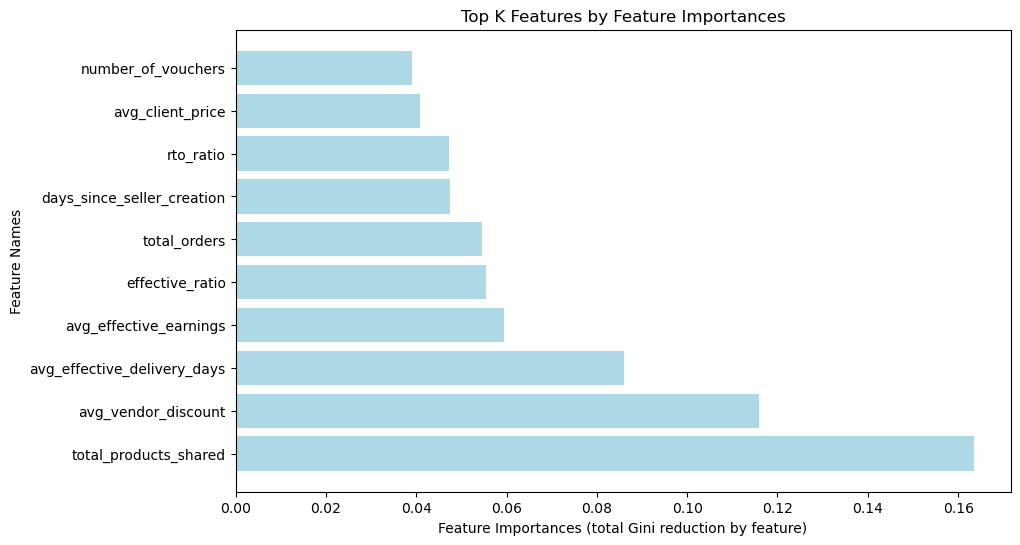

In [56]:
#Feature importance visualization
random_forest = rf_fitted_grid.best_estimator_.named_steps['model']

# Retrieve the features with their respective n ames
feature_importances = random_forest.feature_importances_


feature_names = X_train.columns

# Sort the feature importances desc
indices = np.argsort(feature_importances)[::-1]

#Top K features
top_k_indices = indices[:10]  

# Feature names for the top K features
top_k_feature_names = feature_names[top_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_k_feature_names)), feature_importances[top_k_indices], align='center', color="lightblue")
plt.yticks(range(len(top_k_feature_names)), top_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Top K Features by Feature Importances')
plt.show()

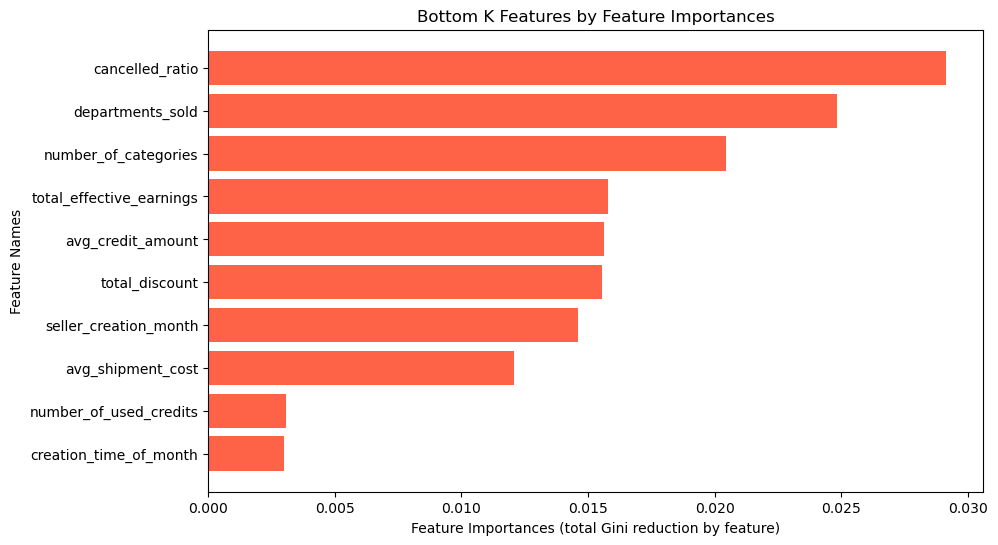

In [54]:
# Indices of the bottom K features
bottom_k_indices = feature_importances.argsort()[4:14]

# Feature names for the bottom K features
bottom_k_feature_names = feature_names[bottom_k_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(bottom_k_feature_names)), feature_importances[bottom_k_indices], align='center', color="tomato")
plt.yticks(range(len(bottom_k_feature_names)), bottom_k_feature_names)
plt.xlabel('Feature Importances (total Gini reduction by feature)')
plt.ylabel('Feature Names')
plt.title('Bottom K Features by Feature Importances')
plt.show()

In [108]:
#Plotting ROC Curve
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, roc_auc_score

# Predicted probabilities from the fitted grid search
y_pred_prob = rf_fitted_grid.predict_proba(X_test)[:, 1]

# FPR, TPR and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC curve 
roc_trace = go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name='ROC Curve (AUC = {:.2f})'.format(auc_score)
)

#Diagonal line trace
diagonal_trace = go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Diagional line (equal measures)',
    line=dict(dash='dash')
)

#Layout & figure
layout = go.Layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    showlegend=True
)

fig = go.Figure(data=[roc_trace, diagonal_trace], layout=layout)


fig.show()

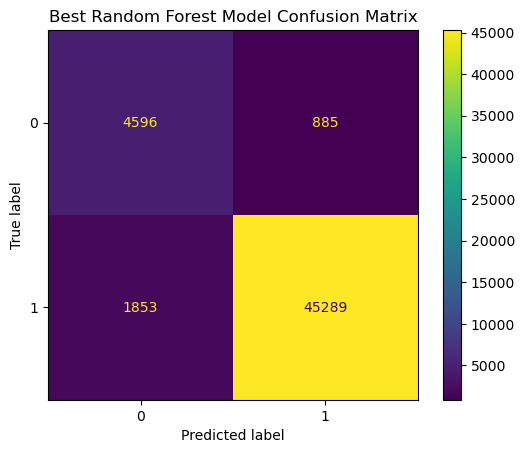

In [23]:
#Confusion Matrix
cm = confusion_matrix(y_test, rf_fitted_grid.predict(X_test), labels=rf_fitted_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_fitted_grid.best_estimator_.classes_)
disp.plot()
plt.title("Best Random Forest Model Confusion Matrix")
plt.show()